# Reference https://ericmjl.github.io/bayesian-stats-talk/

# pymc3 api https://docs.pymc.io/api/plots.html

In [0]:
!pip install -q pymc3
!pip install -q missingno
import pymc3 as pm

In [0]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import seaborn as sns
import missingno as msno



In [7]:
sns.set_style("white")
sns.set_context("poster")

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
!pip install -q pyqrcode
import pyqrcode as pq
icon = pq.create('https://ericmjl.github.io/bayesian-stats-talk')


In [9]:
!ls
import os
os.chdir("/content")

datalab


In [10]:
!ls


datalab


In [0]:
from random import shuffle
total =30
n_heads = 11
n_tails = total-n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

In [0]:
def plot_coins() :
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(list(Counter(tosses).keys()) , list(Counter(tosses).values()))
    ax.set_xticks([0,1])
    ax.set_xticklabels(["tails", "heads"])
    ax.set_ylim(0,20)
    ax.set_yticks(np.arange(0,21,5))
    return fig

In [13]:
print(tosses)

[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]


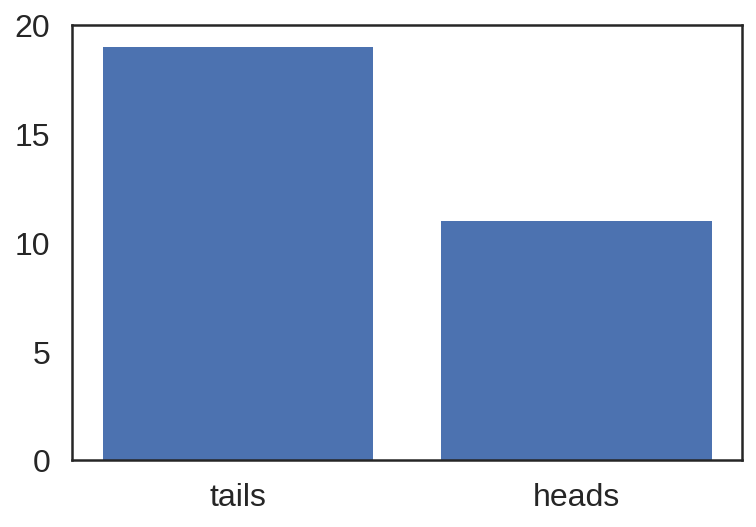

In [14]:
fig = plot_coins()
plt.show()

In [0]:
with pm.Model() as  coin_model :
    p_prior = pm.Uniform("p" , 0, 1)
    like = pm.Bernoulli("likelihood",p= p_prior, observed = tosses ) 

In [16]:
## mcmc inference button (tm)

with coin_model :
    step = pm.Metropolis()
    print(step)
    coin_trace = pm.sample(2000, step = step)

Sequential sampling (2 chains in 1 job)
Metropolis: [p_interval__]
  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:00<00:00, 4796.95it/s]
The number of effective samples is smaller than 25% for some parameters.


<MultiTrace: 2 chains, 1900 iterations, 2 variables>


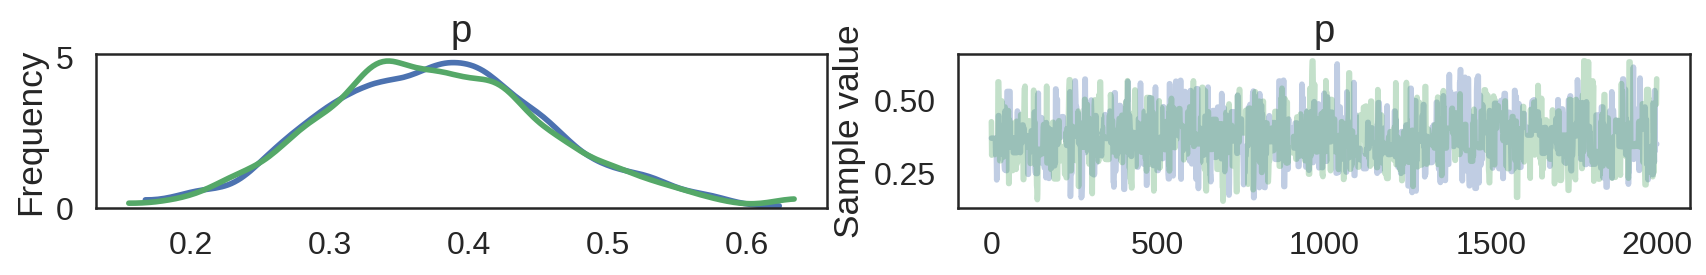

In [17]:
print(coin_trace[100:])
pm.traceplot(coin_trace)
plt.show()

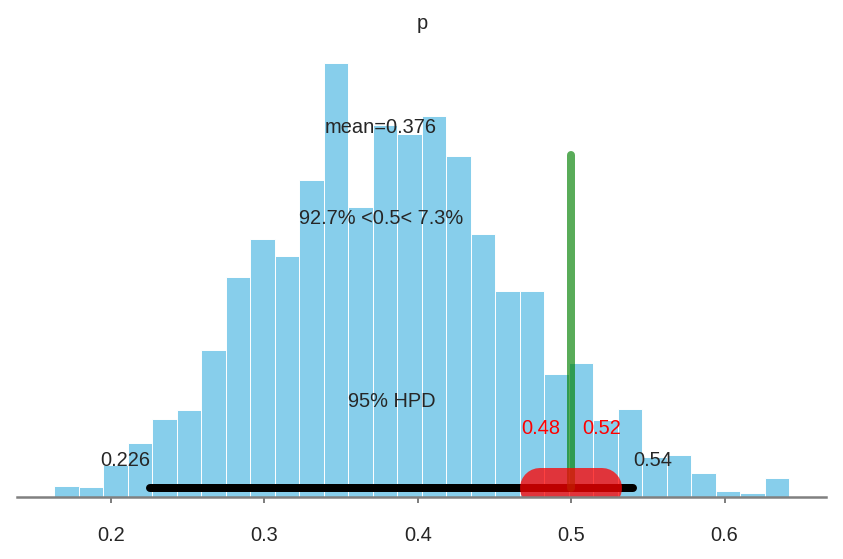

In [18]:
pm.plot_posterior(coin_trace[100:], color='#87ceeb', 
                  rope=[0.48, 0.52], point_estimate='mean', 
                  ref_val=0.5)
plt.show()

## 95% highest posterior density (HPD) encompasses the region of practical equivalence (ROPE). 

In [0]:
## pattern 
### 사후분포를 기반으로 한 해석 
### 모델 구조를 짜기
### 통계적 분포를 사용해서 문제점을 파라미터화하자


## example 2: the chemical activity problem

I have a newly developed molecule X; how good is X in stopping flu replication?

In [19]:
import numpy as np
chem_data = [(0.00080, 99),
(0.00800, 91),
(0.08000, 89),
(0.40000, 89),
(0.80000, 79),
(1.60000, 61),
(4.00000, 39),
(8.00000, 25),
(80.00000, 4)]

import pandas as pd
chem_df = pd.DataFrame(chem_data)
chem_df.columns =["concentration" , "activity"]
chem_df["concentration_log"] = chem_df["concentration"].apply(lambda x: np.log10(x))

chem_df

,concentration,activity,concentration_log
0,0.0008,99,-3.09691
1,0.0080,91,-2.09691
2,0.0800,89,-1.09691
3,0.4000,89,-0.39794
4,0.8000,79,-0.09691
5,1.6000,61,0.20412
6,4.0000,39,0.60206
7,8.0000,25,0.90309
8,80.0000,4,1.90309


In [0]:
## data

def plot_chemical_data(log=True):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    if log:
        ax.scatter(x=chem_df['concentration_log'], y=chem_df['activity'])
        ax.set_xlabel('log10(concentration (mM))', fontsize=20)
    else:
        ax.scatter(x=chem_df['concentration'], y=chem_df['activity'])
        ax.set_xlabel('concentration (mM)', fontsize=20)
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=18)
    ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=18)
    
    plt.hlines(y=50, xmin=min(ax.get_xlim()), xmax=max(ax.get_xlim()), linestyles='--',)
    return fig
        

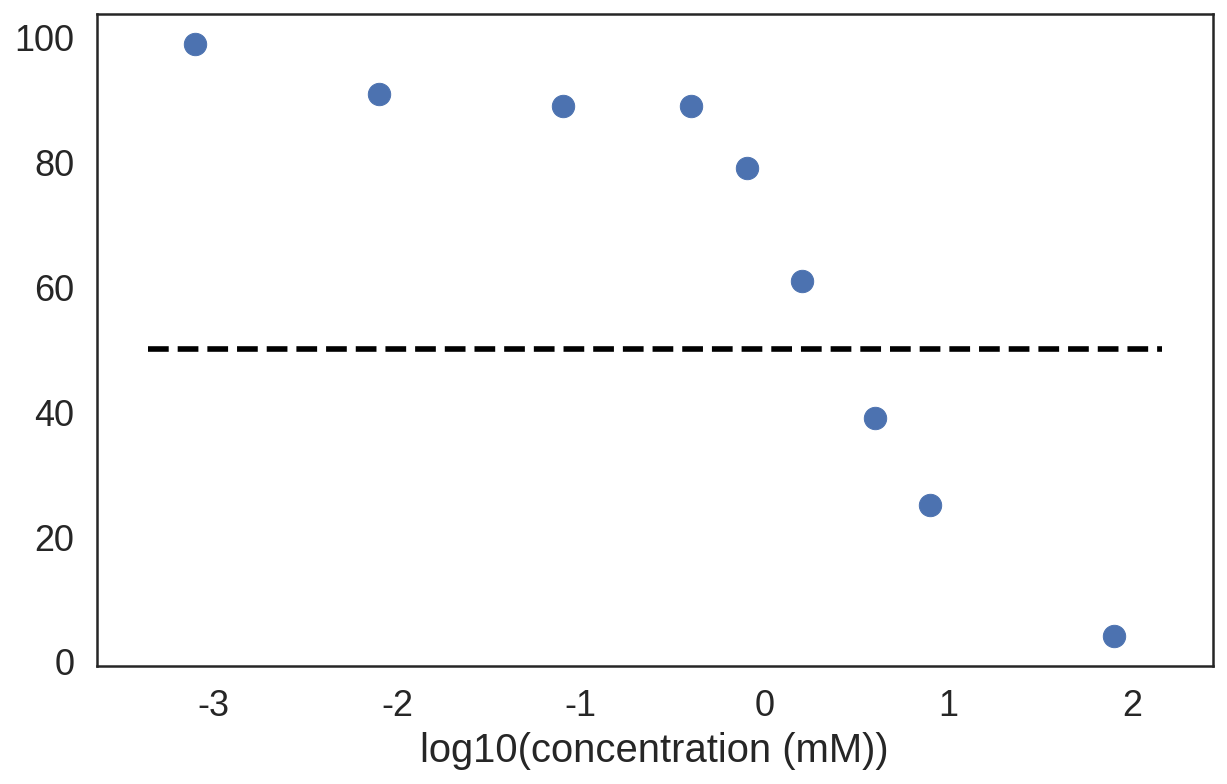

In [21]:
fig = plot_chemical_data(log=True)
plt.show()

In [0]:
## code
import numpy as np
with pm.Model() as ic50_model :
    beta = pm.HalfNormal("beta", sd= 100**2)
    ic50_log10 = pm.Flat('IC50_log10') 
    
    #
    measurements = beta / (1+np.exp( chem_df["concentration_log"].values - ic50_log10 ))
    
    y_like = pm.Normal("y_like", mu=measurements, observed = chem_df["activity"])
    
    ic50 = pm.Deterministic("IC50", np.power(10, ic50_log10))

In [23]:
with ic50_model : 
    step = pm.Metropolis()
    ic50_trace = pm.sample(100000, step= step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [IC50_log10]
>Metropolis: [beta_log__]
 53%|█████▎    | 53164/100500 [00:20<00:18, 2622.69it/s]

100%|██████████| 100500/100500 [00:38<00:00, 2607.44it/s]
The number of effective samples is smaller than 10% for some parameters.




```
pymc3.plots.traceplot(trace, varnames=None, transform=<function identity_transform>, figsize=None, lines=None, combined=False,
                      
                      plot_transformed=False, grid=False, alpha=0.35, priors=None, prior_alpha=1, prior_style='--', 
                      
                      bw=4.5, ax=None, live_plot=False, skip_first=0, refresh_every=100, roll_over=1000)¶
```



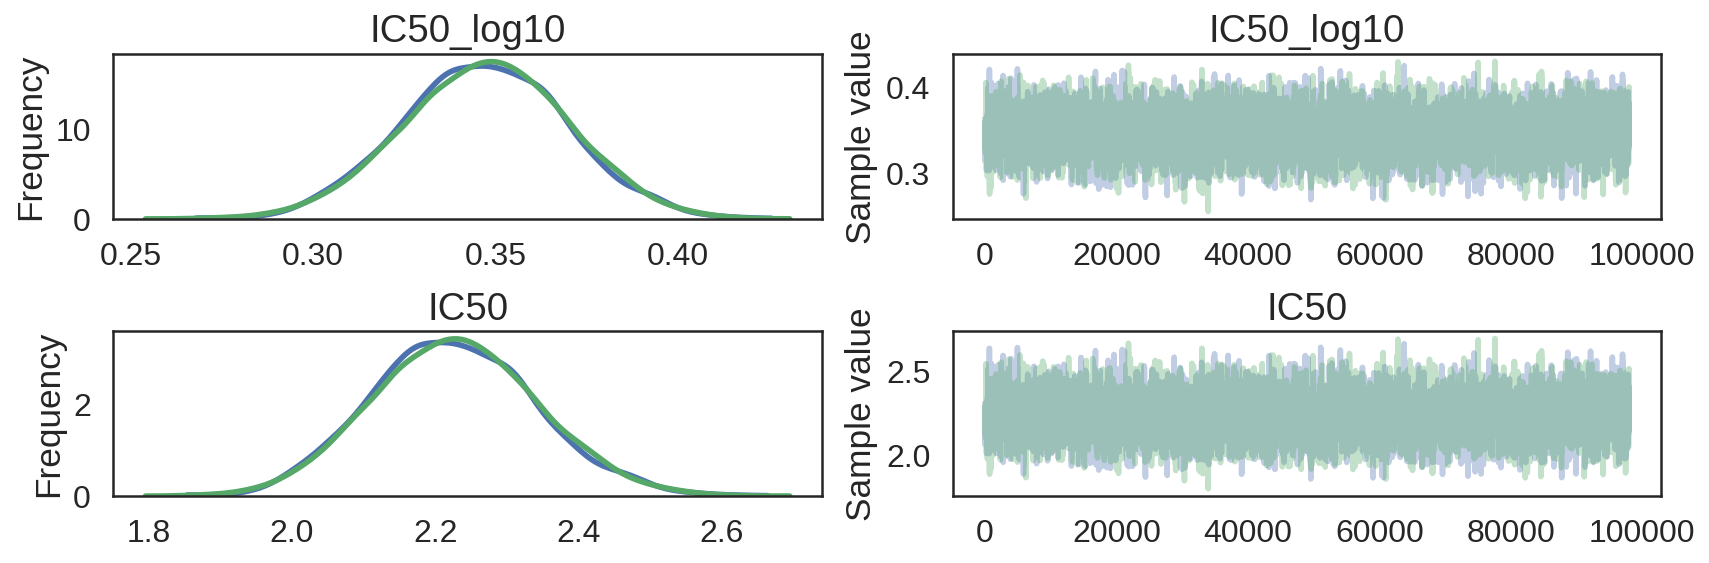

In [24]:
pm.traceplot(ic50_trace[2000: ], varnames =["IC50_log10", "IC50"])
plt.show()



```
pymc3.plots.plot_posterior(trace, varnames=None, transform=<function identity_transform>, figsize=None, text_size=None, 

                            alpha_level=0.05, round_to=3, point_estimate='mean', rope=None, ref_val=None, kde_plot=False, 
                            
                            plot_transformed=False, bw=4.5, ax=None, **kwargs)
```



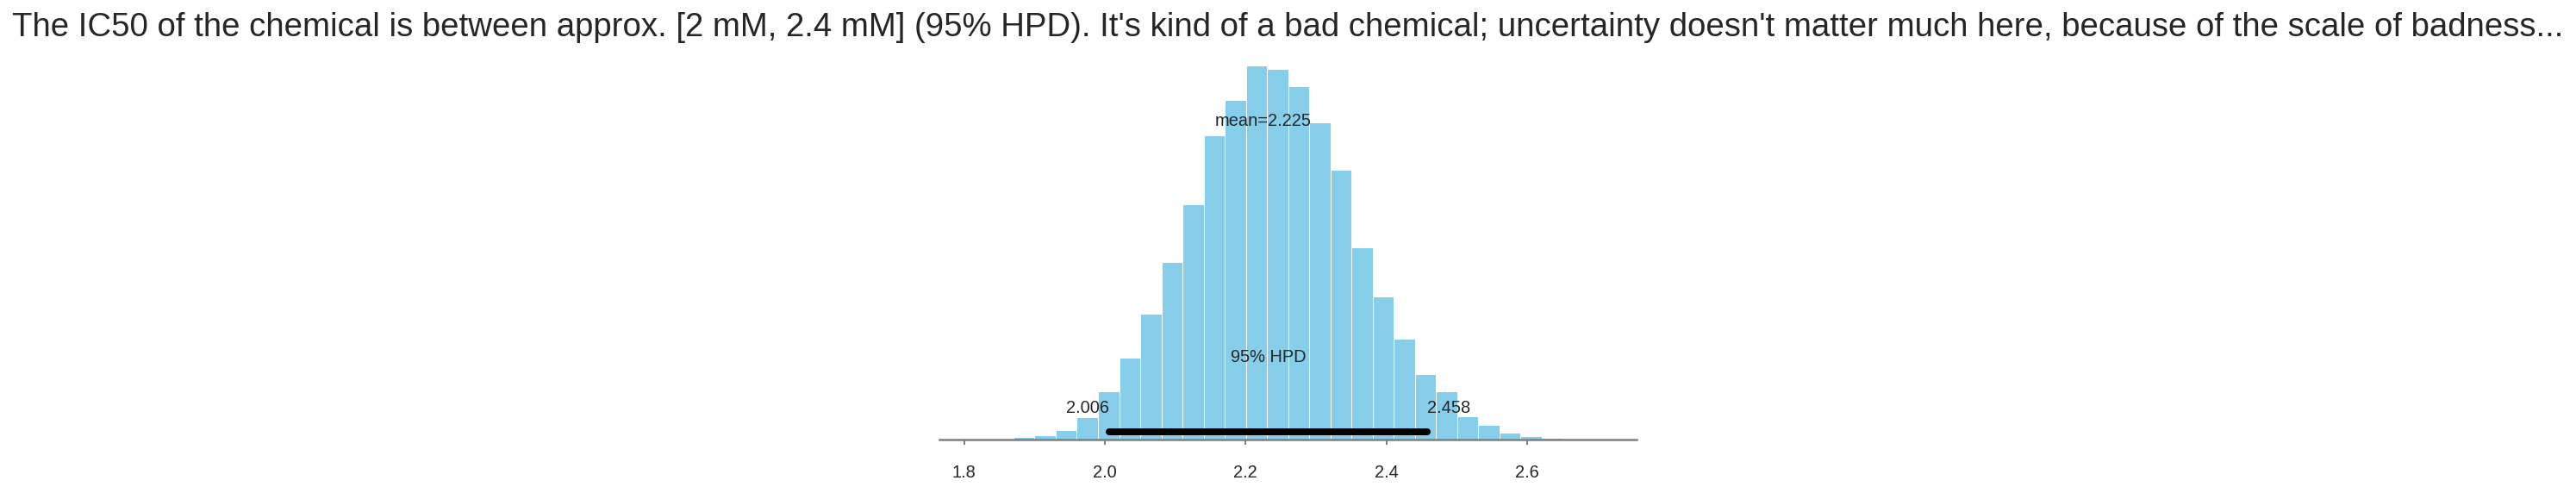

In [25]:
## reuslt 
pm.plot_posterior(ic50_trace[4000:], varnames=["IC50"] , color="#87ceeb" , point_estimate="mean")
plt.title("The IC50 of the chemical is between approx. [2 mM, 2.4 mM] (95% HPD). It's kind of a bad chemical; uncertainty doesn't matter much here, because of the scale of badness...")
plt.show()

## problem type 2: comparison between treatment groups

"are my experimental treatments different from my controls?"

### example 1: the drug IQ problem
does a drug treatment affect IQ scores?

(documented in Kruschke, 2013, example modified from PyMC3 documentation)

In [26]:
drug = [  99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [  95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
         94.,   93.,   99.,   99.,  113.,   96.]

def ECDF(data) :
    x= np.sort(data)
    y= np.cumsum(x) / np.sum(x)
    return x ,y 

def plot_drug():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_drug, y_drug = ECDF(drug)
    ax.plot(x_drug, y_drug, label='drug, n={0}'.format(len(drug)))
    x_placebo, y_placebo = ECDF(placebo)
    ax.plot(x_placebo, y_placebo, label='placebo, n={0}'.format(len(placebo)))
    ax.legend()
    ax.set_xlabel('IQ Score')
    ax.set_ylabel('Cumulative Frequency')
    ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--')
    
    return fig

from scipy.stats import ttest_ind


print("p-value가 0.05보다 작으므로 귀무가설 기각한다. 약 처방이 IQ에 영향을 끼친다라고 할 수 있다. ", 
ttest_ind(drug, placebo))

p-value가 0.05보다 작으므로 귀무가설 기각한다. 약 처방이 IQ에 영향을 끼친다라고 할 수 있다.  Ttest_indResult(statistic=2.280670163432955, pvalue=0.025011500508647616)


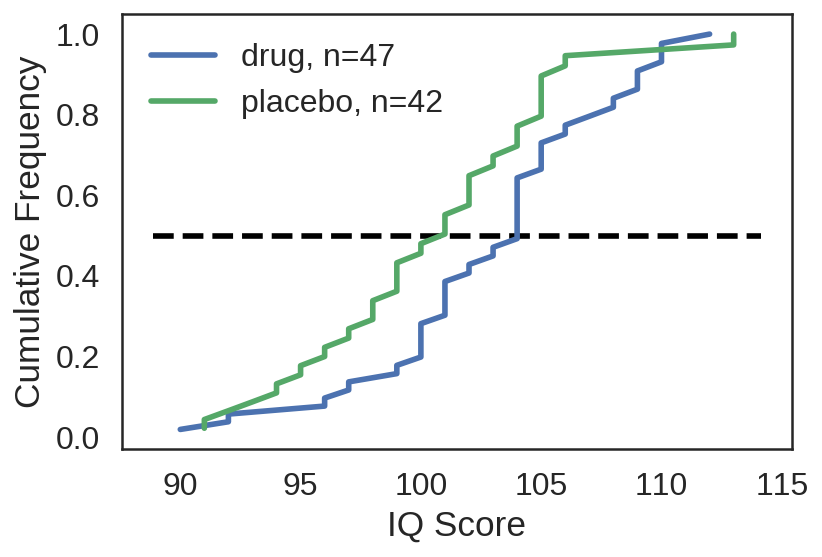

In [27]:
fig = plot_drug()
plt.show()

In [28]:
y_vals = np.concatenate([drug, placebo])
print(y_vals.shape)
labels= ["drug"] *len(drug) + ["placebo"]*len(placebo)

data = pd.DataFrame([y_vals , labels]).T
data.columns = ["IQ", 'treatment']




(89,)




```
pymc3.distributions.continuous.StudentT(nu, mu=0, lam=None, sd=None, *args, **kwargs)


```



In [0]:
with pm.Model() as kruschke_model:
    # Focus on the use of Distribution Objects.
    # Linking Distribution Objects together is done by 
    # passing objects into other objects' parameters.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=drug)
    
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=placebo)
    
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd',  np.sqrt(np.power(sigma_drug, 2) +   np.power(sigma_placebo, 2) / 2))
    
    ## pooled_sd 는 drug_like 와 placebo_like 독립이라는 가정하에  사용한다. 
    effect_size = pm.Deterministic('effect_size',    diff_means / pooled_sd)

In [30]:
with kruschke_model :
    kruschke_trace = pm.sample(10000, step=pm.Metropolis())

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [nu_log__]
>Metropolis: [sigma_placebo_log__]
>Metropolis: [sigma_drug_log__]
>Metropolis: [mu_placebo]
>Metropolis: [mu_drug]
100%|██████████| 10500/10500 [00:12<00:00, 815.24it/s]
The number of effective samples is smaller than 10% for some parameters.


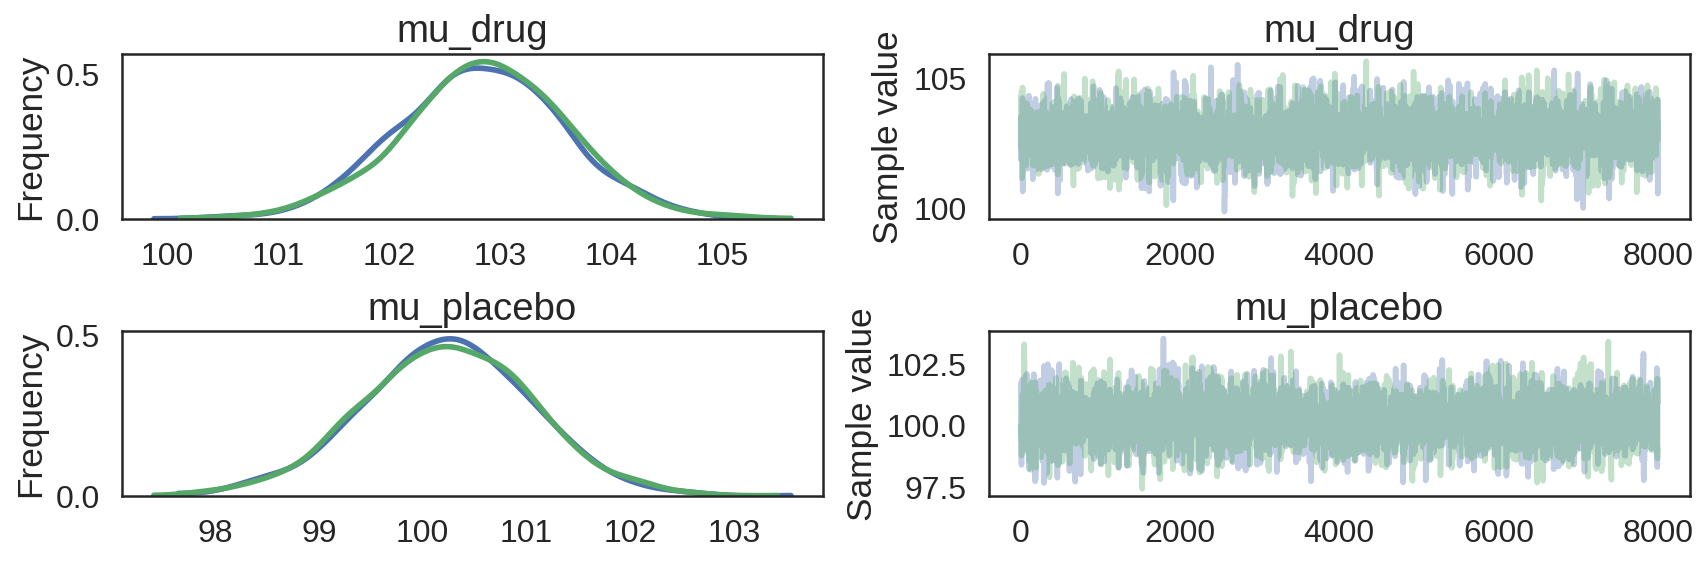

In [31]:
pm.traceplot(kruschke_trace[2000: ] , varnames=["mu_drug", "mu_placebo"])
plt.show()

In [32]:
kruschke_model.deterministics

[sigma_drug, sigma_placebo, nu, diff_means, pooled_sd, effect_size]

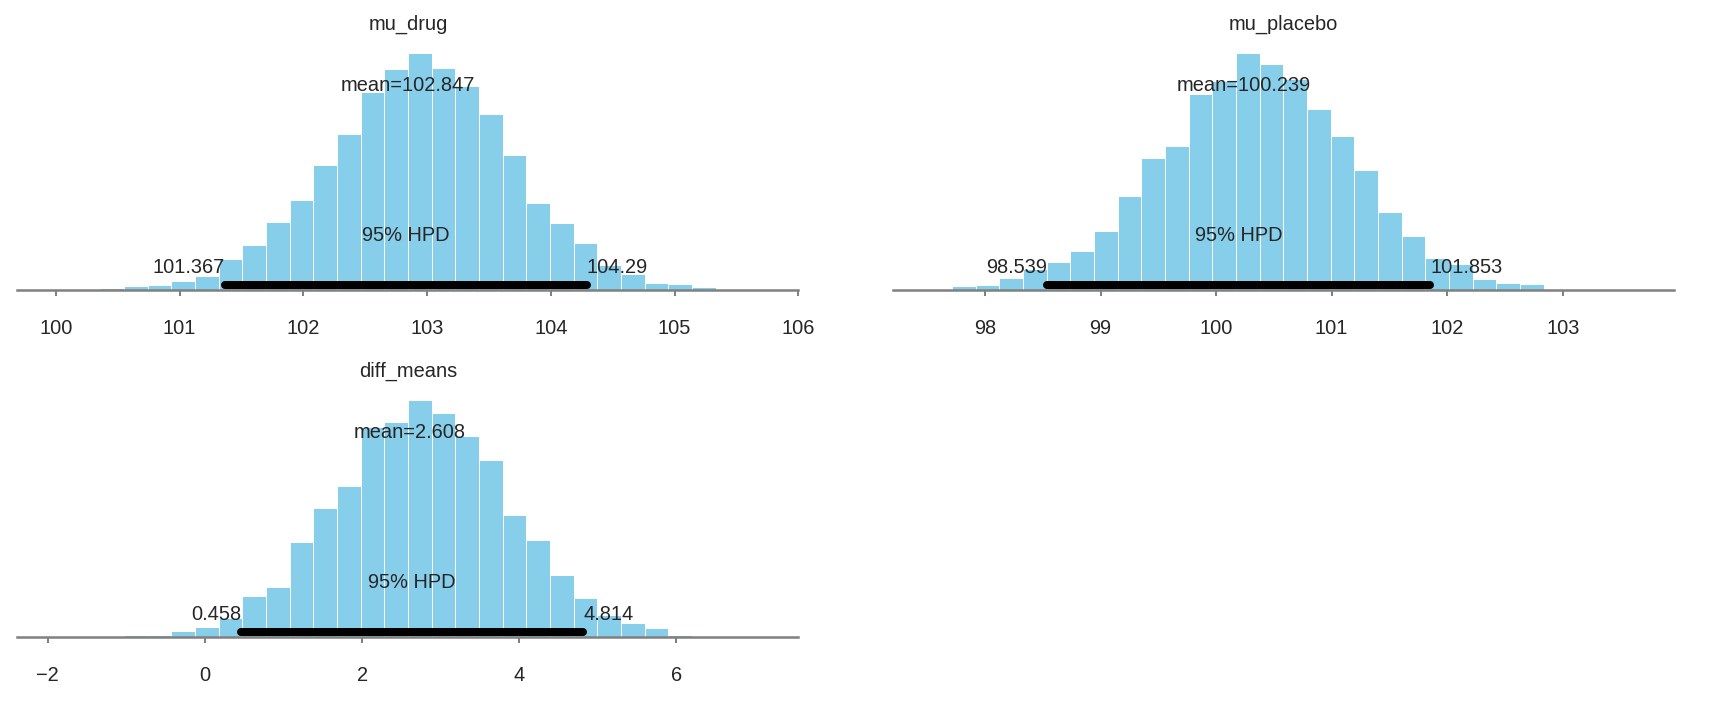

 Difference in mean IQ: [0.5, 4.6]   Frequentist p-value:  0.02  (!!!!!!!!)
  하지만 베이지안으로 하게 되면 그 diff_menas 차이가  2.57로 [0.5 , 4.6] 사이에 있어서 귀무가설(?)이 가각되지 않는다. 그래서 약이 실제로 영향을 끼친다라고 할 수 없다 


In [33]:
pm.plot_posterior(kruschke_trace[2000:], color='#87ceeb',
            varnames=['mu_drug', 'mu_placebo', 'diff_means'])
plt.show()
print(" Difference in mean IQ: [0.5, 4.6] ", " Frequentist p-value:  0.02  (!!!!!!!!)" )
print("  하지만 베이지안으로 하게 되면 그 diff_menas 차이가  2.57로 [0.5 , 4.6] 사이에 있어서 귀무가설(?)이 가각되지 않는다. 그래서 약이 실제로 영향을 끼친다라고 할 수 없다 ")

In [0]:
def get_forestplot_line(ax, kind):
    widths = {'median': 2.8, 'iqr': 2.0, 'hpd': 1.0}
    assert kind in widths.keys(), f'line kind must be one of {widths.keys()}'
    lines = []
    for child in ax.get_children():
        if isinstance(child, mpl.lines.Line2D) and np.allclose(child.get_lw(), widths[kind]):
            lines.append(child)
    return lines

def adjust_forestplot_for_slides(ax):    
    for line in get_forestplot_line(ax, kind='median'):
        line.set_markersize(10)

    for line in get_forestplot_line(ax, kind='iqr'):
        line.set_linewidth(5)

    for line in get_forestplot_line(ax, kind='hpd'):
        line.set_linewidth(3)
        
    return ax

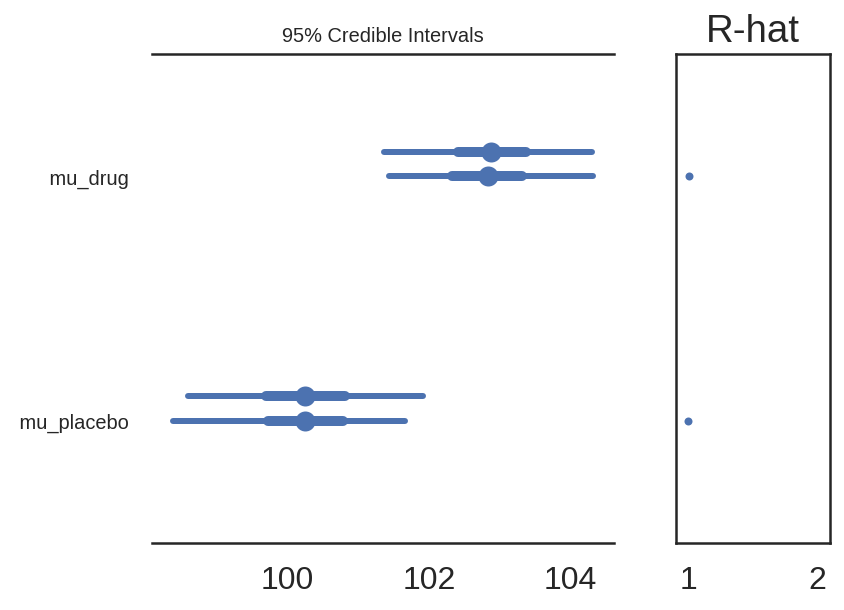

 Forest plot: 95% HPD (thin line), IQR (thicker line), and median (dot) of the posterior distribution on the same axes, allowing us to directly compare the treatment and control. 


In [35]:
pm.forestplot(kruschke_trace[2000:], 
          varnames=['mu_drug', 'mu_placebo'])
ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)
plt.show()

print(" Forest plot: 95% HPD (thin line), IQR (thicker line), and median (dot) of the posterior distribution on the same axes, allowing us to directly compare the treatment and control. ")

In [0]:
def overlay_effect_size(ax):
    height = ax.get_ylim()[1] * 0.5
    ax.hlines(height, 0, 0.2, 'red', lw=5)
    ax.hlines(height, 0.2, 0.8, 'blue', lw=5)
    ax.hlines(height, 0.8, ax.get_xlim()[1], 'green', lw=5)

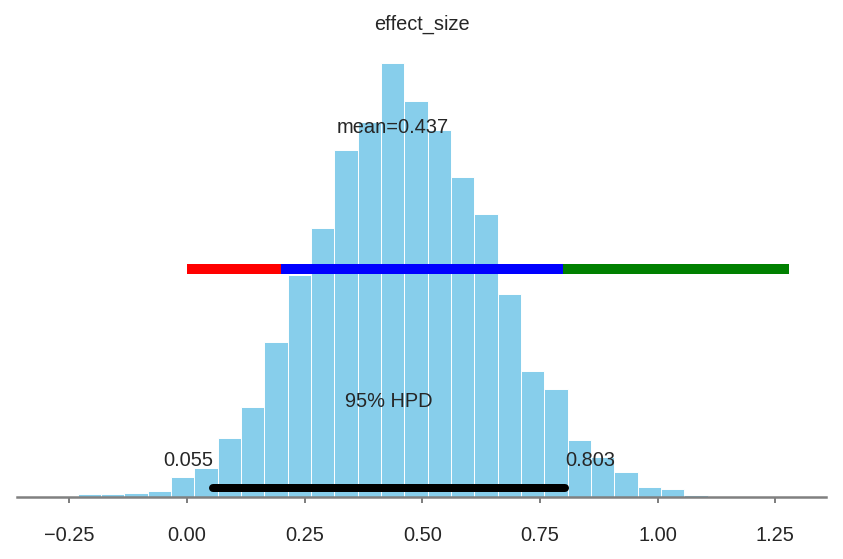

In [37]:
ax = pm.plot_posterior(kruschke_trace[2000:], 
                       varnames=['effect_size'],
                       color='#87ceeb')
overlay_effect_size(ax)

Improvement in IQ is 0-4 points.

The drug is very likely inconsequential.

No evidence of biological significance.

In [38]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [39]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/GPU")
!ls

annotations	    data   filter  images	  imFunctions.py  __pycache__
annotations.tar.gz  drive  graphs  images.tar.gz  output	  torch_gan


In [0]:
renamed_treatments = dict()
renamed_treatments['FBM_2'] = 'FM1'
renamed_treatments['bleachwipe'] = 'CTRL1'
renamed_treatments['ethanol'] = 'CTRL2'
renamed_treatments['kimwipe'] = 'FM2'
renamed_treatments['phonesoap'] = 'FM3'
renamed_treatments['quatricide'] = 'FM4'

data = pd.read_csv('data/pymc3_data/smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']

In [0]:
data = data[data['treatment'] != 'CB30']
data = data[data['treatment'] != 'cellblaster']

# Rename treatments
data['treatment'] = data['treatment'].apply(lambda x: renamed_treatments[x])

# Sort the data according to the treatments.
treatment_order = ['FM1', 'FM2', 'FM3', 'FM4', 'CTRL1', 'CTRL2']
data['treatment'] = data['treatment'].astype('category')

In [46]:
print(data[0:10])
data['treatment'].cat.set_categories(treatment_order, inplace=True)
data['treatment'] = data['treatment'].cat.codes.astype('int32')
data = data.sort_values(['treatment']).reset_index(drop=True)
data['site'] = data['site'].astype('category').cat.codes.astype('int32')

data['frac_change_colonies'] = ((data['colonies_post'] - data['colonies_pre']) 
                                / data['colonies_pre'])
data['frac_change_colonies'] = pm.floatX(data['frac_change_colonies'])
del data['screen protector']

# Change dtypes to int32 for GPU usage.
def change_dtype(data, dtype='int32'):
    return data.astype(dtype)

cols_to_change_ints = ['sample_id', 'colonies_pre', 'colonies_post',
                       'morphologies_pre', 'morphologies_post', 'phone ID']

cols_to_change_floats = ['year', 'month', 'day', 'perc_reduction morph',
                         'phone ID', 'no case',]

for col in cols_to_change_ints:
    data[col] = change_dtype(data[col], dtype='int32')
    
for col in cols_to_change_floats:
    data[col] = change_dtype(data[col], dtype='float32')

data.dtypes



   sample_id treatment  colonies_pre  colonies_post  morphologies_pre  \
0          1       FM3             0              0                 0   
1          2       FM3            12              0                 3   
2          3       FM3            14              4                 5   
3          4     CTRL2             0              0                 0   
4          5     CTRL2             0              1                 0   
5          6     CTRL2             1              0                 1   
6          7       FM3            19              0                 7   
7          8       FM3            29              0                 3   
8          9       FM3            50              8                 8   
9         10     CTRL1             0              0                 0   

   morphologies_post    year  month   day  perc_reduction morph      site  \
0                  0  2015.0   10.0   7.0                   NaN     phone   
1                  0  2015.0   10.0   7.0 

sample_id                 int32
treatment                 int32
colonies_pre              int32
colonies_post             int32
morphologies_pre          int32
morphologies_post         int32
year                    float32
month                   float32
day                     float32
perc_reduction morph    float32
site                      int32
phone ID                float32
no case                 float32
frac_change_colonies    float64
dtype: object

In [0]:
def plot_colonies_data():
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2,1,1)
    sns.swarmplot(x='treatment', y='colonies_pre', data=data, ax=ax1)
    ax1.set_title('pre-treatment')
    ax1.set_xlabel('')
    ax1.set_ylabel('colonies')
    ax2 = fig.add_subplot(2,1,2)
    sns.swarmplot(x='treatment', y='colonies_post', data=data, ax=ax2)
    ax2.set_title('post-treatment')
    ax2.set_ylabel('colonies')
    ax2.set_ylim(ax1.get_ylim())
    plt.tight_layout()
    return fig

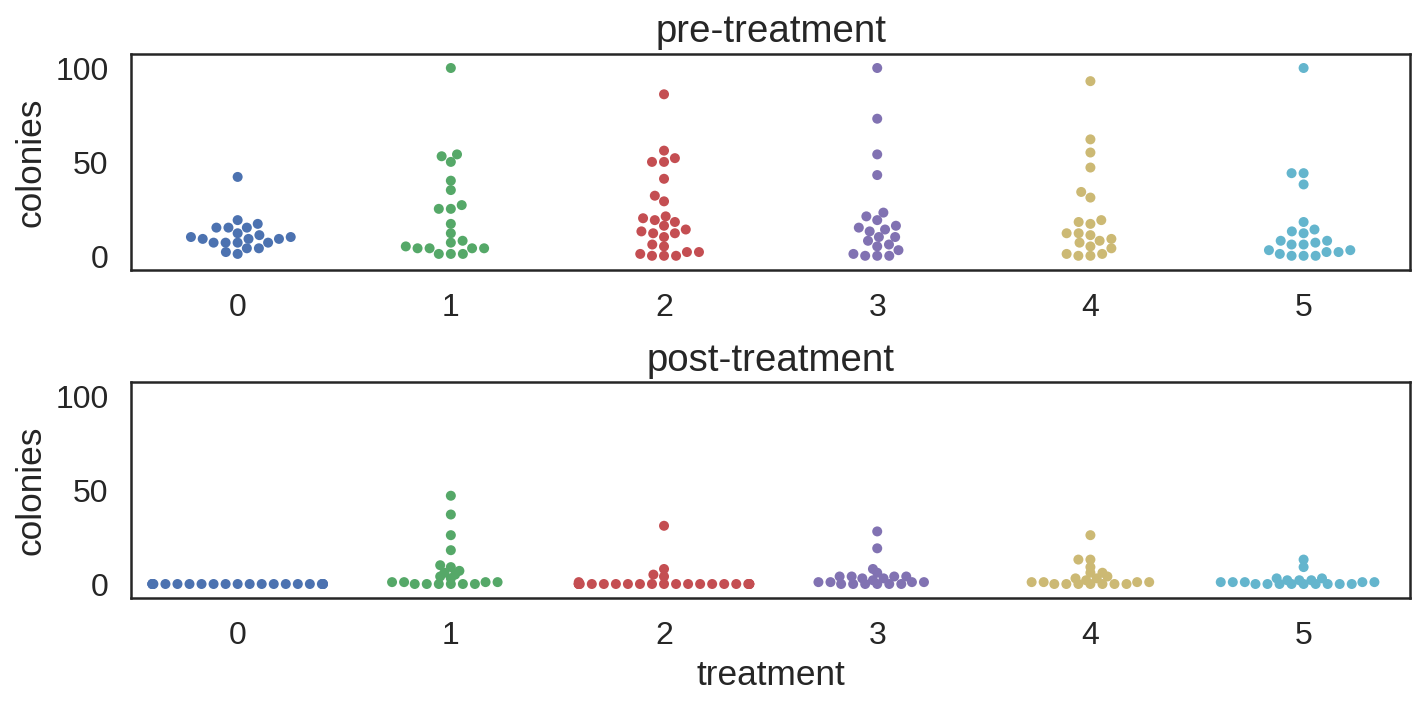

In [48]:
fig = plot_colonies_data()
plt.show()

In [0]:
## likelihood ~ poisson  ## prior uniform

In [0]:
with pm.Model() as poisson_estimation:
    
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=10000, 
                                shape=len(treatment_order))
    pre_mus = mu_pre[data['treatment'].values]  # fancy indexing!!
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, 
                            observed=pm.floatX(data['colonies_pre']))
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=10000, 
                                 shape=len(treatment_order))
    post_mus = mu_post[data['treatment'].values]  # fancy indexing!!
    post_counts = pm.Poisson('post_counts', mu=post_mus, 
                             observed=pm.floatX(data['colonies_post']))

    perc_change = pm.Deterministic('perc_change', 
                                   100 * (mu_pre - mu_post) / mu_pre)     

In [52]:
with poisson_estimation :
    poisson_trace = pm.sample(2000000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [post_mus]
>Metropolis: [pre_mus]
  9%|▉         | 184805/2000500 [01:05<10:42, 2826.45it/s]

100%|██████████| 2000500/2000500 [11:37<00:00, 2867.68it/s]


100%|██████████| 2000500/2000500 [11:37<00:00, 2867.98it/s]


The number of effective samples is smaller than 10% for some parameters.


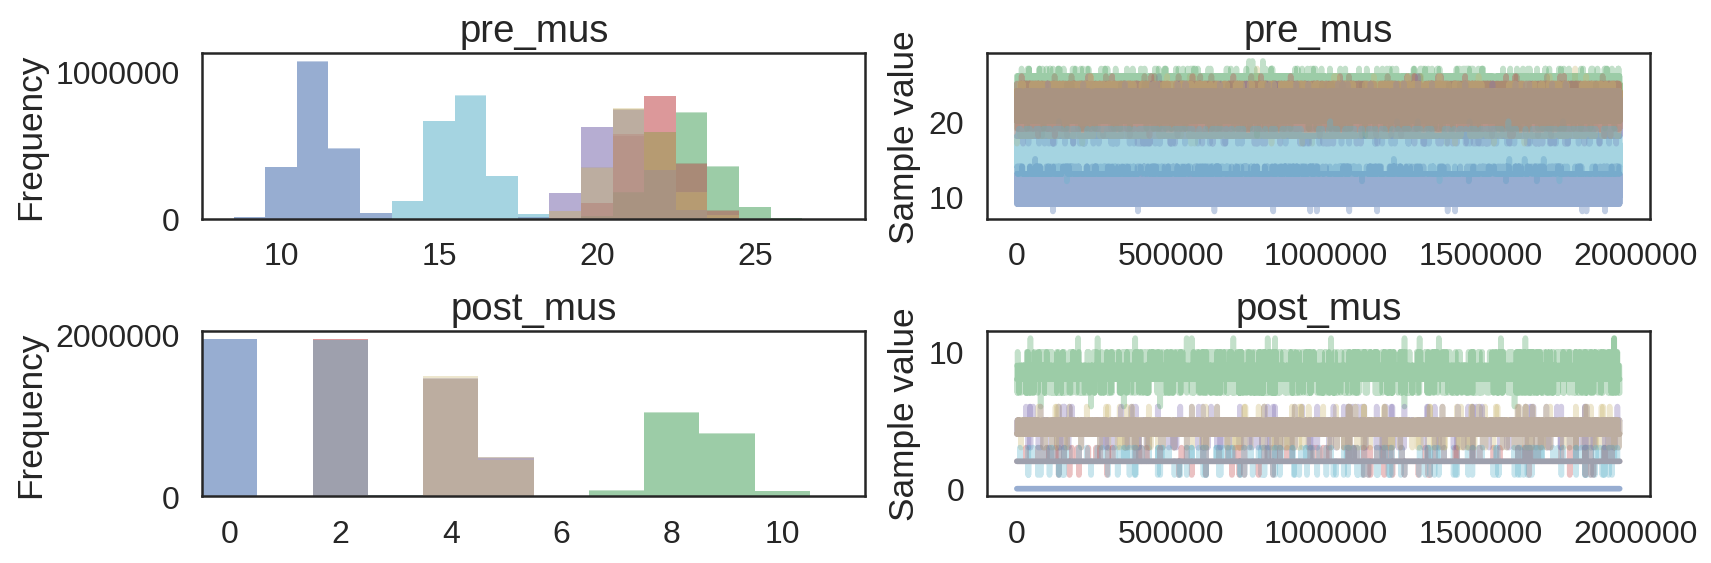

In [53]:
pm.traceplot(poisson_trace[50000:], varnames =["pre_mus", "post_mus"])
plt.show()

## Result

In [1]:
pm.forestplot(poisson_trace[50000:], varnames =["per_change"] , ylabels = treatment_order , range=[0,110])
plt.xlabel("Percentage Reduction")

ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)

NameError: ignored